Load required packages

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

plt.style.use('seaborn-white')
%matplotlib inline

Some plotting functions to help you plot the ROC curve

In [66]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for house price > 200,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


Load the Sacramento housing data

In [67]:
sac = pd.read_csv('../assets/datasets/Sacramentorealestatetransactions.csv')

Create a binary variable where 1 indicates a house sold for over 200,000 and 0 indicates a house sold for equal to or less than 200,000.

Subset the data to just contain the number of beds, baths, the sq ft, and the over 200k indicator variable.

In [68]:
sac['price_over_200000'] = sac['price'].map(lambda x: 1 if x > 200000 else 0)

In [69]:
sac.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,price_over_200000
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0


Split your data into training and testing sets. The predictors are the beds, baths, and sq ft. The feature is the over 200k class variable. Make the test size 33% (and optionally stratify by the over 200k class).

In [70]:
sac.columns.values

array(['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type',
       'sale_date', 'price', 'latitude', 'longitude', 'price_over_200000'], dtype=object)

In [71]:
features = ['beds', 'baths', 'sq__ft']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(sac[features].values, sac['price_over_200000'], test_size=0.33)

Fit a logistic regression on the training data.

In [84]:
logr = LogisticRegression()
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Print out the confusion matrix

In [85]:
y_pred = logr.predict(X_test)

In [86]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['over_200k', 'under_200k'],
                         columns=['predicted_over_200k','predicted_under_200k'])

print(confusion)

            predicted_over_200k  predicted_under_200k
over_200k                   133                    39
under_200k                   88                    66


Calculate the accuracy, precision, and recall. What can these three metrics tell you about your model?

In [87]:
accuracy_score(y_test, y_pred)

0.61042944785276076

accuracy = (TP+TN) / all  
- out of all your labels, how many were correct?  

Only 56% of our predictions were correct

In [88]:
precision_score(y_test, y_pred)

0.60180995475113119

precision = TP / (FP+TP)  

- out of everything you labelled as positive, how many were actually positive?  

Out of everything we predicted as over 200k, only 58% were actually over 200k

In [89]:
recall_score(y_test, y_pred)

0.77325581395348841

recall = TP / (TP+FN)  

- out of everything that is actually positive, how many did you actually label correctly as positive?

Out of everything that was actually over 200k, our predictions found 70% of them

In [93]:
# The difference between precision and recall can be tricky to interpret. The intuition here is
# that precision is a measure of the QUALITY of results: of the houses labeled as over 200k,
# how many of those were correct?
# Recall, on the other hand, is a measure of the COMPLETENESS of results: of all the houses
# that sold for over 200k, how many were identified by the classifier?
# On the flip side, you can have a high precision but identify very few of the total 200k houses.
# Likewise, you can have a high recall but also incorrectly identify many under 200k houses
# as over 200k houses.

Say as a real estate agent, I prioritize minimizing false positives (predicting a house will sell for over 200k when it actually sells for under) because false positives make me lose money.

Change the decision threshold to **lower the false positive rate** and then print out the new confusion matrix. What is the downside to lowering the false positive rate?

In [94]:
y_pp = pd.DataFrame(logr.predict_proba(X_test), columns = ['below 200k', 'over 200k'])
y_pp['actual'] = np.array(y_test)
y_pp['threshold-50'] = y_pp['over 200k'].map(lambda x: 1 if x > 0.5 else 0)
y_pp['threshold-70'] = y_pp['over 200k'].map(lambda x: 1 if x > 0.7 else 0)

In [95]:
y_pp.head(20)

,below 200k,over 200k,actual,threshold-50,threshold-70
0,0.379791,0.620209,1,1,0
1,0.597048,0.402952,0,0,0
2,0.548349,0.451651,1,0,0
3,0.425492,0.574508,0,1,0
4,0.019076,0.980924,0,1,1
5,0.312587,0.687413,1,1,0
6,0.310852,0.689148,1,1,0
7,0.555902,0.444098,1,0,0
8,0.382616,0.617384,1,1,0
9,0.620586,0.379414,1,0,0


To reduce false positive rate: 

- you want to reduce the number of false items that you labeled as true
    - you want to reduce the number of cheap houses you label as more thank 200k
- you want to increase the threshold so that more items are treated as 200k or below
- The downside to lowering the false positive rate is that the false negative rate increases.

In [96]:
conmat2 = confusion_matrix(y_test, y_pp['threshold-70'], labels=[1,0])
confusion2 = pd.DataFrame(conmat2, index=['over_200k', 'under_200k'],
                         columns=['predicted_over_200k','predicted_under_200k'])

print confusion2

            predicted_over_200k  predicted_under_200k
over_200k                    38                   134
under_200k                    4                   150


Plot the ROC curve using the plotting function provided.

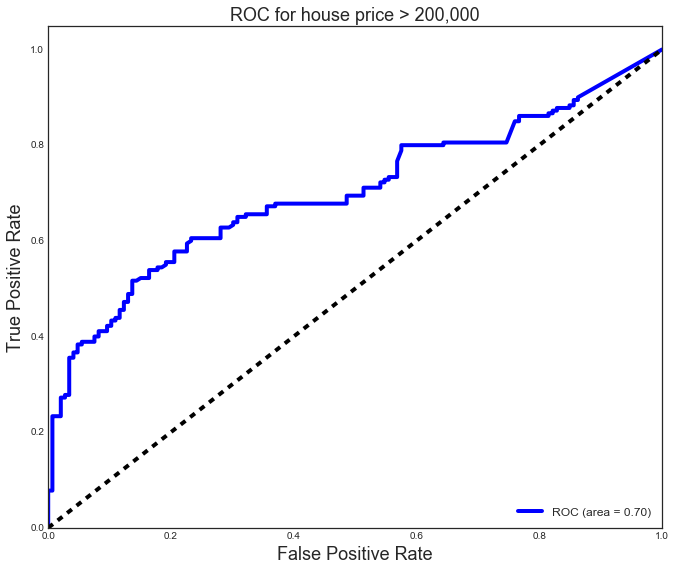

In [82]:
y_score = logr.decision_function(X_test)
plot_roc(y_test, y_score)

Bonus: when might precision and recall be more useful than the ROC?

Precision and recall are more useful when the proportion of the positive class is smaller, since they are sensitive to this.